In [2]:
import ee
import geemap

## Estimating Forest Cover Density and Land Area Coverage for Nigeria States

I am using the [FAO GAUL: Global Administrative Unit Layers 2015, First-Level Administrative Units](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level1) from FAO UN for extracting the study area (roi) and the [Global 4-class PALSAR-2/PALSAR Forest/Non-Forest Map](https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_PALSAR_YEARLY_FNF4#bands) from JAXA EORC for the Forest Cover Analysis.

In [3]:
# extracting region of interest (Nigeria) from the FAO Administrative Units Data

m = geemap.Map(center=[9,7], zoom=6, height='500px')
nija = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM0_NAME', 'Nigeria'))
m.addLayer(nija, {}, 'Nigeria Boundary')
m

Map(center=[9, 7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [4]:
dataset = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF4').filterDate('2020-01-01', '2020-12-31').select('fnf')
dataset

In [14]:
m = geemap.Map()

legend_dict = {
    '1 Dense Forest': '#00b200',
    '2 Non-dense Forest': '#83ef62',
    '3 Non-Forest': '#ffff99',
    '4 Water': '#0000ff',
}

fnfVis = {
  'min': 1,
  'max': 4,
  'palette': ['00b200','83ef62','ffff99','0000ff'],
}

vis_params = {
    'color': '#000000',
    'width': 1,
    'lineType': 'solid',
    'fillColor': '00000000',
}

fnf = dataset.map(lambda img: img.clipToCollection(nija))
m.centerObject(nija, zoom=6)
m.addLayer(fnf, fnfVis, 'Forest/Non-Forest')
m.addLayer(nija.style(**vis_params), {}, 'Nigeria')
text = 'Map Created by Emeka Orji'
text2 = 'Data Source: JAXA EORC and FAO UN'
m.add_text(text2, position='bottomleft', fontsize=10)
m.add_text(text)
m.add_legend(title='Forest/Non-Forest Classification', legend_dict=legend_dict, layer_name='Forest/Non-Forest')
m

Map(center=[9.589444610453397, 8.089338153274129], controls=(WidgetControl(options=['position', 'transparent_b…

In [15]:
fc = geemap.zonal_stats_by_group(fnf, nija, out_file_path=None, stat_type='SUM', decimal_places=2, denominator=1e3, return_fc=True)

Computing ... 


In [16]:
# Converting the google earth engine feature to dataframe and checking for state with highest land area of dense forest (Class_1) in Nigeria

nija_fnf = geemap.ee_to_df(fc)
nija_fnf.sort_values('Class_1', ascending=False).head(10)

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,Class_1,Class_2,Class_3,Class_4,Class_sum,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng
35,182,Nigeria,2239,Taraba,10463501.25,19697316.96,29361913.34,907485.67,60430217.22,NO,3000,Member State,1000,4.957189,13.739033
19,182,Nigeria,2217,Cross River,10304715.15,8291732.60,2067155.84,346123.06,21009726.65,NO,3000,Member State,1000,1.715713,10.919583
2,182,Nigeria,65700,Bayelsa,3476323.66,4943250.81,984105.55,587587.72,9991267.74,NO,3000,Member State,1997,0.814464,8.485513
8,182,Nigeria,65706,Ondo,2716024.75,10063289.18,1578986.84,110852.72,14469153.49,NO,3000,Member State,1997,1.183914,8.104566
20,182,Nigeria,2218,Delta,2663738.87,9215861.06,4347974.56,546265.38,16773839.87,NO,3000,Member State,1000,1.369407,11.554842
21,182,Nigeria,2219,Edo,2370242.42,13686654.38,3430423.51,101788.79,19589109.10,NO,3000,Member State,1000,1.601900,7.455604
28,182,Nigeria,2228,Kogi,1942287.27,19426078.35,7177105.15,395950.74,28941421.51,NO,3000,Member State,1000,2.372238,9.657707
14,182,Nigeria,2211,Adamawa,1938542.65,6101819.85,25977915.49,373243.32,34391521.31,NO,3000,Member State,1000,2.830909,11.814723
33,182,Nigeria,2234,Osun,1926435.70,5885827.53,1320943.26,56601.48,9189807.97,NO,3000,Member State,1000,0.752934,4.380049
10,182,Nigeria,65708,Rivers,1648666.17,4469795.63,2160206.09,447940.66,8726608.55,NO,3000,Member State,1997,0.711474,10.311515


In [17]:
# Visualizing Region with Dense Forest in Square Kilometer (converting from kilometer to square kilometer using numpy sqrt function) 

import numpy as np

nija_fnf['class_1_km2'] = (np.sqrt(nija_fnf[['Class_1']])).round(2)

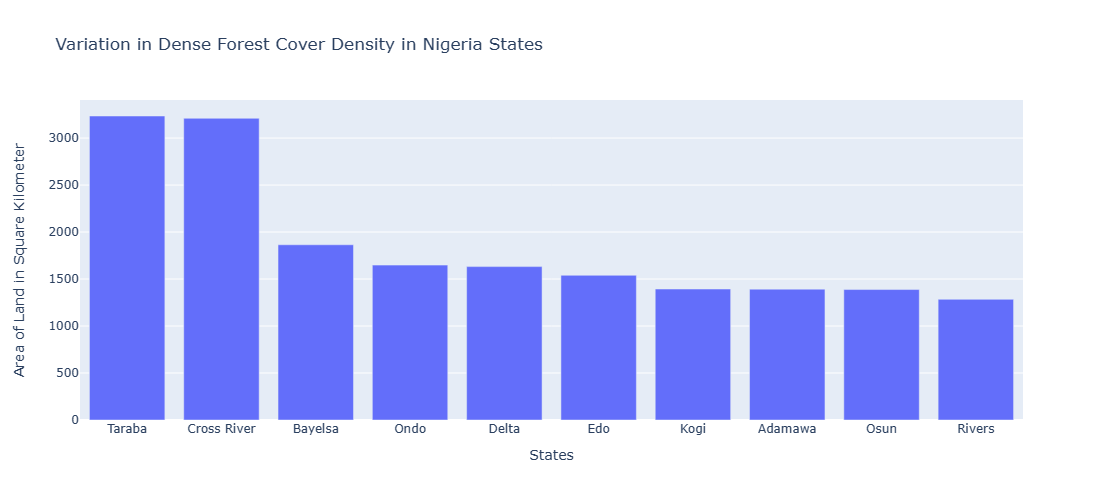

In [18]:
geemap.bar_chart(data=nija_fnf, x='ADM1_NAME', y='class_1_km2', x_label= 'States', y_label='Area of Land in Square Kilometer', 
                 title='Variation in Dense Forest Cover Density in Nigeria States',max_rows=10)

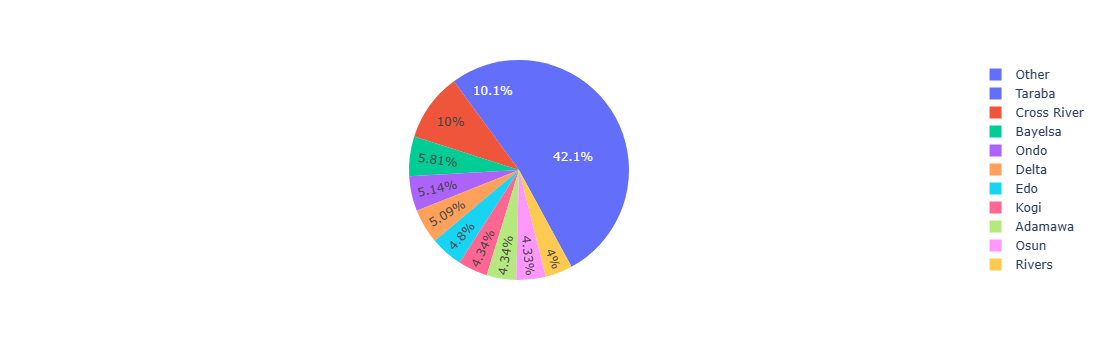

In [19]:
geemap.pie_chart(nija_fnf, names='ADM1_NAME', values='class_1_km2', max_rows=11, color='ADM1_NAME')

### Evaluating Variation in Dense Forest Land Cover in South-East and South-South States of Nigeria

In [20]:
m = geemap.Map(center=[9,7], zoom=6, height='500px')
ss_se_states = nija.filter(
    ee.Filter.inList('ADM1_NAME', ['Edo', 'Akwa Ibom', 'Cross River', 'Rivers', 'Bayelsa', 'Delta', 'Imo', 'Abia', 'Anambra', 'Ebonyi', 'Enugu'])
)
imo = ss_se_states.filter(ee.Filter.eq('ADM1_NAME', 'Imo'))
m.centerObject(imo, zoom=8)
m.addLayer(ss_se_states, {}, 'SS / SE States Boundary')
m

Map(center=[5.550234088402793, 7.0468337804945], controls=(WidgetControl(options=['position', 'transparent_bg'…

In [21]:
from geemap.legends import builtin_legends

for legend in builtin_legends:
    print(legend)

NLCD
ESA_WorldCover
ESRI_LandCover
ESRI_LandCover_TS
Dynamic_World
NWI
MODIS/051/MCD12Q1
MODIS/006/MCD12Q1
GLOBCOVER
JAXA/PALSAR
Oxford
AAFC/ACI
COPERNICUS/CORINE/V20/100m
COPERNICUS/Landcover/100m/Proba-V/Global
USDA/NASS/CDL
ALOS_landforms


In [22]:
m = geemap.Map()

legend_dict = {
    '1 Dense Forest': '#00b200',
    '2 Non-dense Forest': '#83ef62',
    '3 Non-Forest': '#ffff99',
    '4 Water': '#0000ff',
}

fnfVis = {
  'min': 1,
  'max': 4,
  'palette': ['00b200','83ef62','ffff99','0000ff'],
}

vis_params = {
    'color': '#000000',
    'width': 2,
    'lineType': 'solid',
    'fillColor': '00000000',
}

se_fnf = dataset.map(lambda img: img.clipToCollection(ss_se_states))
m.centerObject(imo, zoom=8)
m.addLayer(se_fnf, fnfVis, 'Forest/Non-Forest')
m.addLayer(ss_se_states.style(**vis_params), {}, 'SS States')
text = 'Map Created by Emeka Orji'
m.add_text(text)
text2 = 'Data Source: JAXA EORC and FAO UN'
m.add_text(text2, position='bottomleft', fontsize=10)
m.add_legend(title='Forest/Non-Forest Classification', legend_dict=legend_dict)
m

Map(center=[5.550234088402793, 7.0468337804945], controls=(WidgetControl(options=['position', 'transparent_bg'…

In [23]:
m.add_labels(
    data=ss_se_states,
    column="ADM1_NAME",
    font_size="8pt",
    font_color="black",
    font_family="arial",
    font_weight="bold",
    draggable=True,
)

#### To Download resulting Image to my local computer with less spatial resolution(i.e using a scaling:250) image is originally 25m resolution

In [24]:
region = ee.Geometry.BBox(4.713751, 4.107652, 9.725036, 7.865649)
fc = ee.FeatureCollection(region)
m.addLayer(fc, {}, 'region', False)

In [25]:
sefnf = se_fnf.first()
m.addLayer(sefnf, fnfVis, 'SE Forest/Non-Forest', shown=False)
sefnf

In [26]:
project = sefnf.projection()
project

In [27]:
crs = project.crs()

In [28]:
geemap.download_ee_image(sefnf, filename='testing_cover.tif', scale=250, crs=crs, region=region)

testing_cover.tif: |                                                  | 0.00/3.74M (raw) [  0.0%] in 00:00 (et…

In [29]:
fc = geemap.zonal_stats_by_group(fnf, ss_se_states, out_file=None, stat_type='SUM', decimal_places=2, denominator=1e3, return_fc=True)

Computing ... 


In [30]:
ss_se_fnf = geemap.ee_to_df(fc)
ss_se_fnf.sort_values('Class_1', ascending=False)

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,Class_1,Class_2,Class_3,Class_4,Class_sum,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng
7,182,Nigeria,2217,Cross River,10304715.15,8291732.60,2067155.84,346123.06,21009726.65,NO,3000,Member State,1000,1.715713,10.919583
1,182,Nigeria,65700,Bayelsa,3476323.66,4943250.81,984105.55,587587.72,9991267.74,NO,3000,Member State,1997,0.814464,8.485513
8,182,Nigeria,2218,Delta,2663738.87,9215861.06,4347974.56,546265.38,16773839.87,NO,3000,Member State,1000,1.369407,11.554842
9,182,Nigeria,2219,Edo,2370242.42,13686654.38,3430423.51,101788.79,19589109.10,NO,3000,Member State,1000,1.601900,7.455604
4,182,Nigeria,65708,Rivers,1648666.17,4469795.63,2160206.09,447940.66,8726608.55,NO,3000,Member State,1997,0.711474,10.311515
0,182,Nigeria,65698,Abia,656347.04,3043332.46,1014053.82,10150.57,4723883.89,NO,3000,Member State,1997,0.385485,4.198984
3,182,Nigeria,65703,Enugu,621607.32,4906438.59,2162196.82,12177.81,7702420.54,NO,3000,Member State,1997,0.629751,4.118491
10,182,Nigeria,2222,Imo,505895.05,3742845.18,1027544.60,33826.55,5310111.38,NO,3000,Member State,1000,0.433385,2.713051
5,182,Nigeria,2212,Akwa Ibom,421385.16,4439529.32,1668316.43,81822.73,6611053.64,NO,3000,Member State,1000,0.539042,6.186270
6,182,Nigeria,2213,Anambra,237814.63,1762223.52,2493468.06,96628.83,4590135.04,NO,3000,Member State,1000,0.375060,3.465664


In [31]:
ss_se_fnf['class_1_km2'] = (np.sqrt(ss_se_fnf[['Class_1']])).round(2)

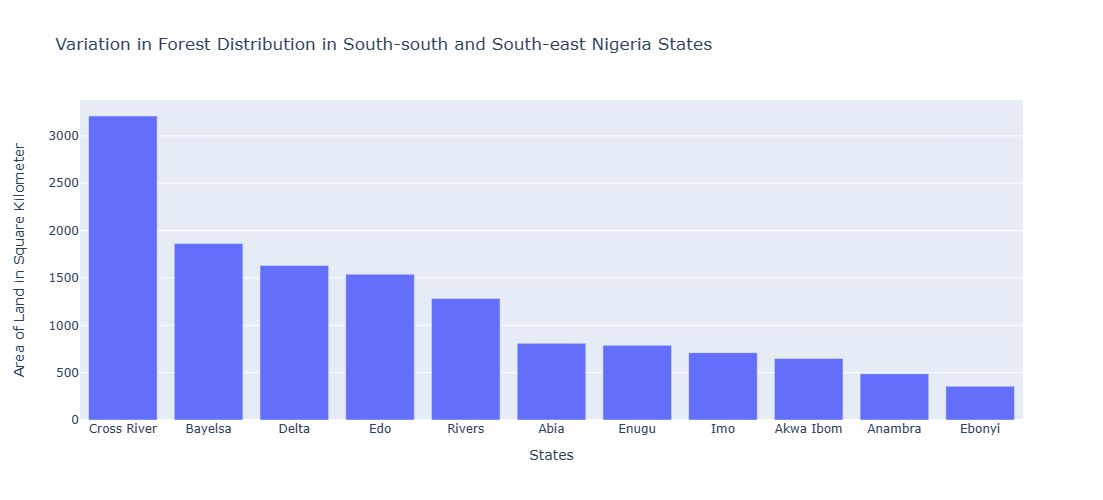

In [33]:
geemap.bar_chart(data=ss_se_fnf, x='ADM1_NAME', y='class_1_km2', x_label= 'States', y_label='Area of Land in Square Kilometer', 
                 title='Variation in Forest Distribution in South-south and South-east Nigeria States')

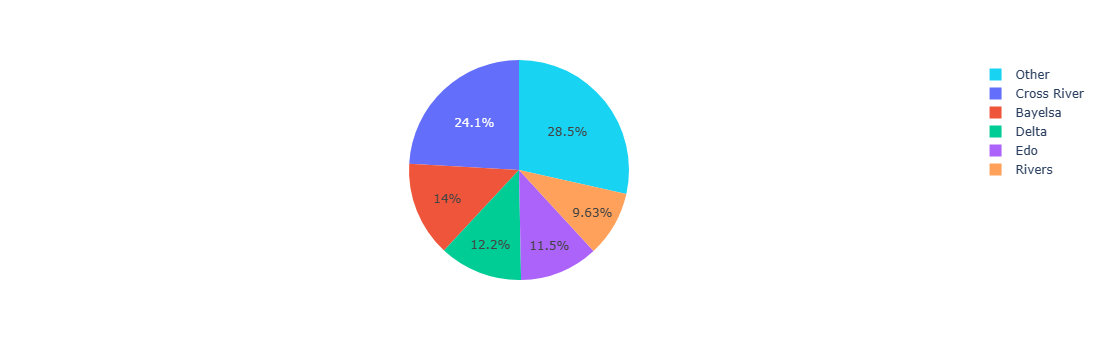

In [34]:
geemap.pie_chart(ss_se_fnf, names='ADM1_NAME', values='class_1_km2', max_rows=6, color='ADM1_NAME')

## Evaluating Disparity in Dense Forest Region in North Eastern Nigeria

In [35]:
m = geemap.Map()
ne_states = nija.filter(
    ee.Filter.inList('ADM1_NAME', ['Adamawa', 'Bauchi', 'Borno', 'Gombe', 'Taraba', 'Yobe'])
)
gombe = ne_states.filter(ee.Filter.eq('ADM1_NAME', 'Gombe'))
m.centerObject(gombe, zoom=7)
m.addLayer(ne_states, {}, 'North Eastern States Boundary')
m

Map(center=[10.404839156412304, 11.244955239828244], controls=(WidgetControl(options=['position', 'transparent…

In [36]:
m = geemap.Map()

legend_dict = {
    '1 Dense Forest': '#00b200',
    '2 Non-dense Forest': '#83ef62',
    '3 Non-Forest': '#ffff99',
    '4 Water': '#0000ff',
}

fnfVis = {
  'min': 1,
  'max': 4,
  'palette': ['00b200','83ef62','ffff99','0000ff'],
}

vis_params = {
    'color': '#000000',
    'width': 2,
    'lineType': 'solid',
    'fillColor': '00000000',
}


fnf = dataset.map(lambda img: img.clipToCollection(ne_states))
m.centerObject(gombe, zoom=7)
m.addLayer(nija.style(fillColor='00000000', width=0.5), {}, 'Nigeria')
m.addLayer(fnf, fnfVis, 'NE Forest/Non-Forest')
m.addLayer(ne_states.style(**vis_params), {}, 'NE States')
text = 'Map Created by Emeka Orji'
m.add_text(text)
text2 = 'Data Source: JAXA EORC and FAO UN'
m.add_text(text2, position='bottomleft', fontsize=10)
m.add_legend(title='Forest/Non-Forest Classification', legend_dict=legend_dict, layer_name='NE Forest/Non-Forest')
m

Map(center=[10.404839156412304, 11.244955239828244], controls=(WidgetControl(options=['position', 'transparent…

In [37]:
m.add_labels(
    data=ne_states,
    column="ADM1_NAME",
    font_size="8pt",
    font_color="black",
    font_family="arial",
    font_weight="bold",
    draggable=True,
)

In [38]:
fc = geemap.zonal_stats_by_group(fnf, ne_states, out_file=None, stat_type='SUM', decimal_places=2, denominator=1e3, return_fc=True)

Computing ... 


In [39]:
ne_fnf = geemap.ee_to_df(fc)
ne_fnf.sort_values('Class_1', ascending=False)

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,Class_1,Class_2,Class_3,Class_4,Class_sum,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng
4,182,Nigeria,2239,Taraba,10463501.25,19697316.96,29361913.34,907485.67,60430217.22,NO,3000,Member State,1000,4.957189,13.739033
2,182,Nigeria,2211,Adamawa,1938542.65,6101819.85,25977915.49,373243.32,34391521.31,NO,3000,Member State,1000,2.830909,11.814723
0,182,Nigeria,65699,Bauchi,444962.46,5976093.83,42311666.39,327299.00,49060021.68,NO,3000,Member State,1997,4.055679,12.903322
1,182,Nigeria,65704,Gombe,67632.93,890539.12,16907147.48,324910.87,18190230.40,NO,3000,Member State,1997,1.501908,5.521496
3,182,Nigeria,2216,Borno,25983.06,3582335.06,67208534.99,779015.02,71595868.13,NO,3000,Member State,1000,5.941520,13.717056
5,182,Nigeria,2240,Yobe,1847.98,545128.13,44908084.84,117440.68,45572501.63,NO,3000,Member State,1000,3.787278,10.339501


In [40]:
ne_fnf['class_1_km2'] = (np.sqrt(ne_fnf[['Class_1']])).round(2)

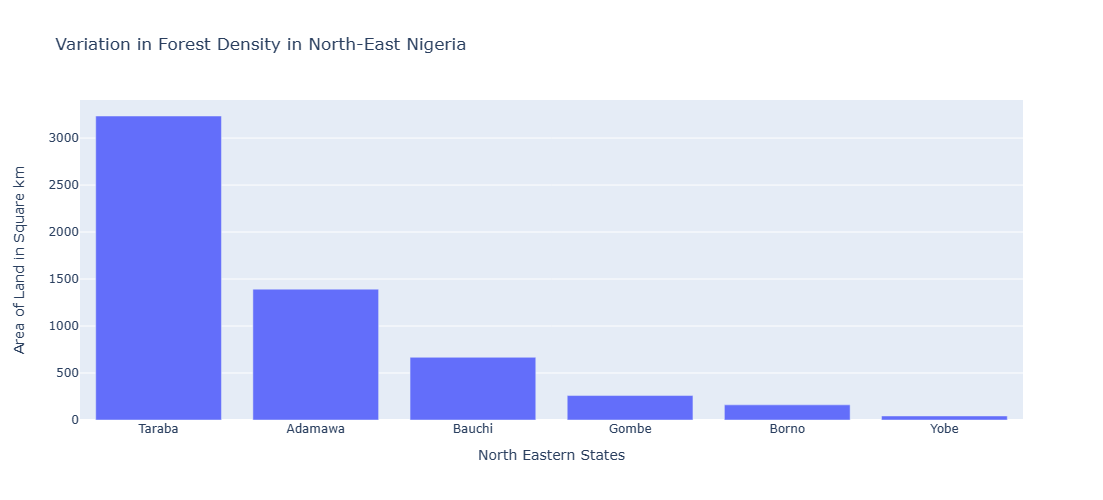

In [42]:
geemap.bar_chart(data=ne_fnf, x='ADM1_NAME', y='class_1_km2', x_label= 'North Eastern States', y_label='Area of Land in Square km', 
                 title='Variation in Forest Density in North-East Nigeria')

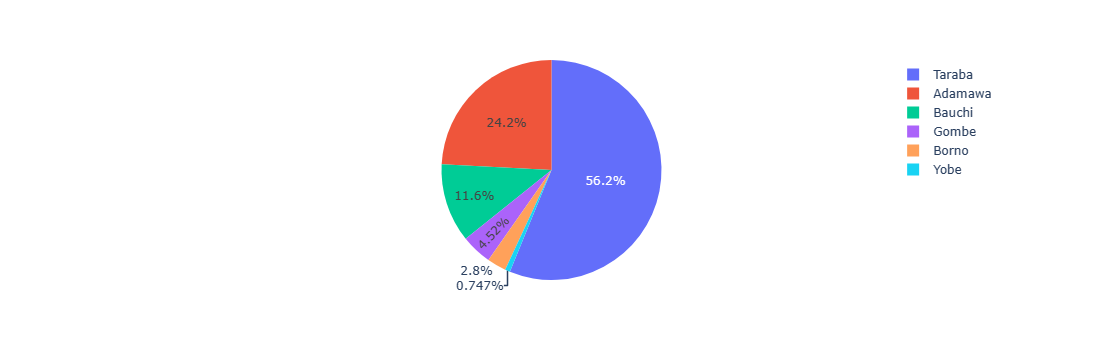

In [43]:
geemap.pie_chart(ne_fnf, names='ADM1_NAME', values='class_1_km2', color='ADM1_NAME')